# PCA on 4000 Spectra

Recreating https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/dimensionality_reduction.html with 4000 spectra generated from compute_sdss_pca.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA

## 1. Load data, filter galaxies and mask zero errors

In [55]:
data = np.load('spec4000error.npz')

In [80]:
galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]
z = data['z'][galaxy_ind]

In [74]:
spec_err = data['spec_err'][galaxy_ind]
spec_err = preprocessing.normalize(spec_err)
ind = spec_err == 0.
mask = np.empty(spec_err.shape)
mask[:] = np.NaN
spec_err[ind] = mask[ind]

## 2. Normalise X and plot mean spectrum

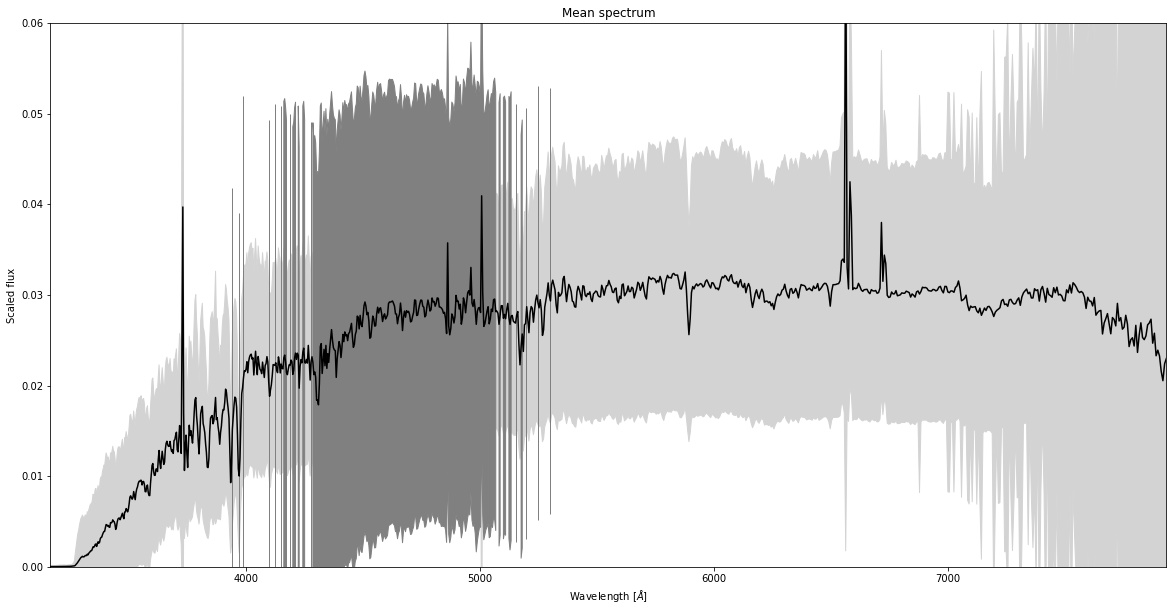

In [81]:
X_normal = preprocessing.normalize(X)
mu = X_normal.mean(0)
std = X_normal.std(0)
avg_spec_err = spec_err.mean(0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey')
plt.fill_between(wavelengths, mu - avg_spec_err, mu + avg_spec_err , color = 'grey')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.show()

## 3. Apply PCA

In [21]:
pca = PCA(n_components=4)
X_red = pca.fit_transform(X_normal)

## 4. Plot the first two components of reduced X against each other

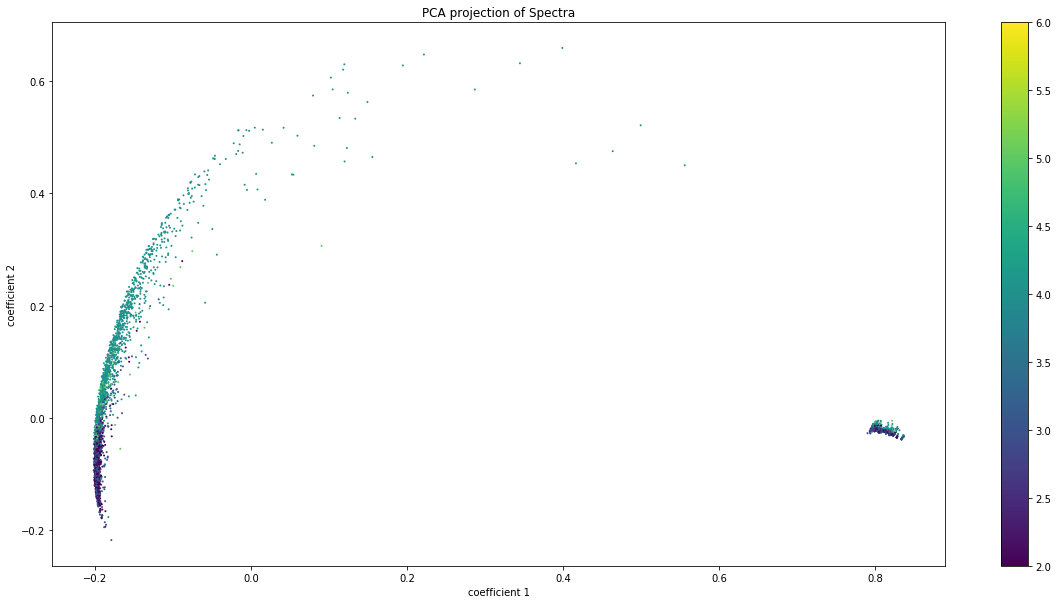

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(X_red[:, 0], X_red[:, 1], c = subclass, s=4, lw=0, vmin=2, vmax=6)
plt.colorbar()
plt.xlabel('coefficient 1')
plt.ylabel('coefficient 2')
plt.title('PCA projection of Spectra')
plt.show()

## 5. Plot the mean spectrum and the first four eigenvectors of the spectral data

Text(0.5, 1.0, 'Mean Spectrum and Eigen-spectra')

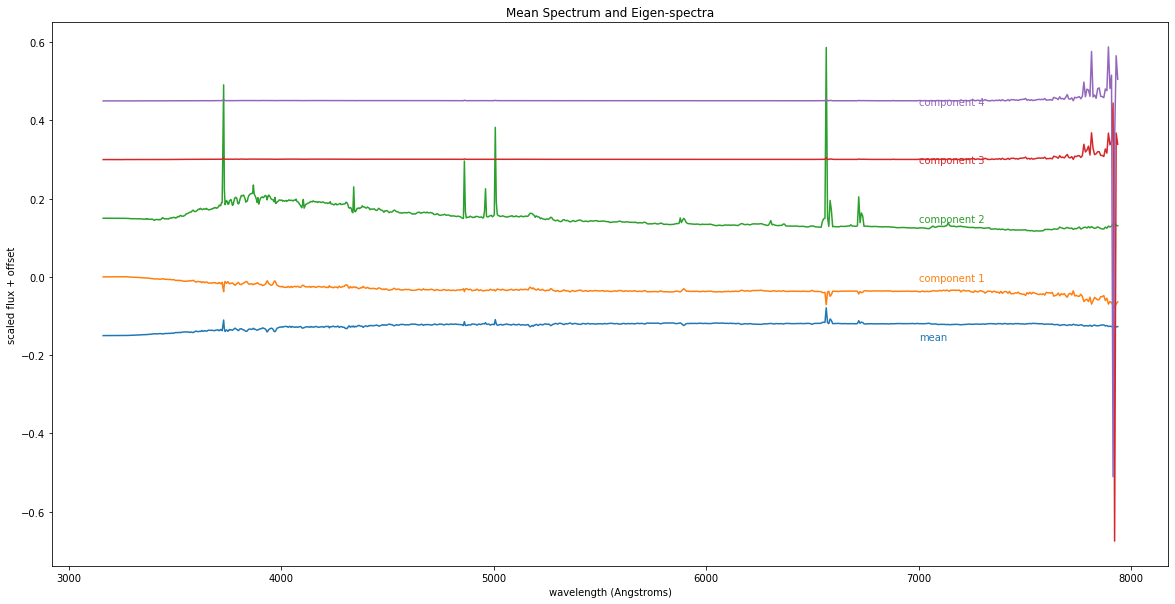

In [39]:
plt.figure(figsize=(20,10))
l = plt.plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = plt.plot(wavelengths, pca.components_[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
#plt.ylim(-0.2, 0.6)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Scaled flux + offset')
plt.title('Mean Spectrum and Eigen-spectra')

## 6. Repeat with our own PCA function to compare

In [48]:
def PCA_fs(X,n_components=None):
    ''' PCA function adapted from https://www.askpython.com/python/examples/principal-component-analysis
    Input:
    X: numpy nd.array
    n_components: Denotes the number of principal components; can be integer or None with default as n_components = None.
                  If None, function will automatically the optimal number of principal components based by finding the maximum
                  decrease in added variance %
    Returns:
    X_reduced: The dataset with redu

    '''
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    S = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    evals , evecs = np.linalg.eigh(S)
    evals = np.flip(evals)
    evecs = np.flip(evecs, axis = 1)
     
    #Step-4
    var = evals/np.sum(evals)
    cum_var = np.cumsum(var)
    
    plt.figure(figsize=(20,10))
    plt.plot(np.array(range(1,len(evals)+1)), var, label = 'Variance %', color = 'tab:blue')
    plt.plot(np.array(range(1,len(evals)+1)), var, 'x', color = 'tab:blue', markersize = 10)
    plt.plot(np.array(range(1,len(evals)+1)), cum_var, label = 'Cumulative variance %', color = 'tab:green')
    plt.plot(np.array(range(1,len(evals)+1)), cum_var, '+', color = 'tab:green', markersize = 10)
    plt.xlabel('Number of principal components')
    plt.ylabel('Variance %')
    plt.xticks(np.array(range(1,len(evals)+1)))
    plt.legend()
    plt.show()
    
    var_diff = [var[i] - var[i+1] for i in range(len(var)-1)]
    if n_components == None:
        n_components = var_diff.index(max(var_diff))+1
        print('Optimal number of principal components:', n_components)
    
    #Step-5
    evecs_subset = evecs[:,0:n_components]
    X_reduced = np.dot(evecs_subset.transpose(), X_meaned.transpose()).transpose()
     
    return X_reduced, evals, evecs

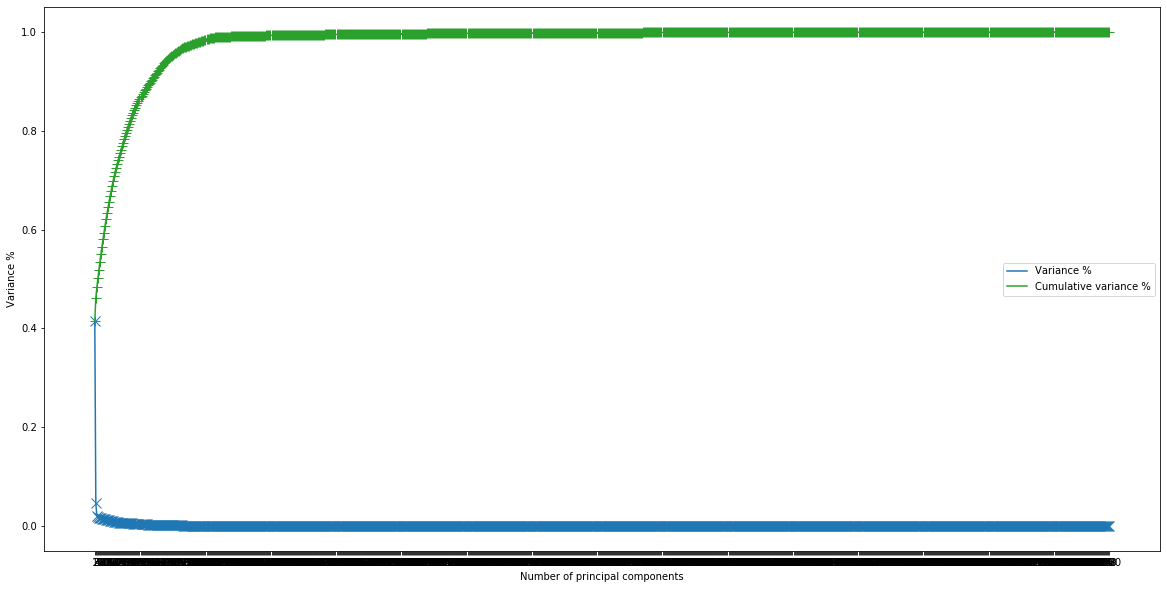

In [49]:
X_fs, evals_fs, evecs_fs = PCA_fs(X_normal, n_components=4)

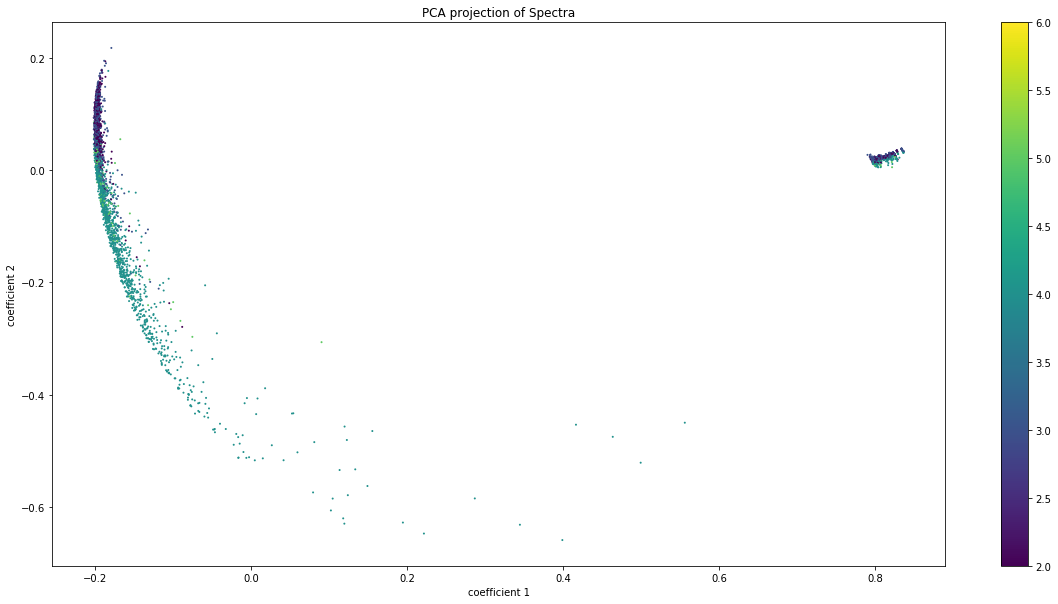

In [50]:
plt.figure(figsize=(20,10))
plt.scatter(X_fs[:, 0], X_fs[:, 1], c = subclass, s=4, lw=0, vmin=2, vmax=6)
plt.colorbar()
plt.xlabel('coefficient 1')
plt.ylabel('coefficient 2')
plt.title('PCA projection of Spectra')
plt.show()

Text(0.5, 1.0, 'Mean Spectrum and Eigen-spectra')

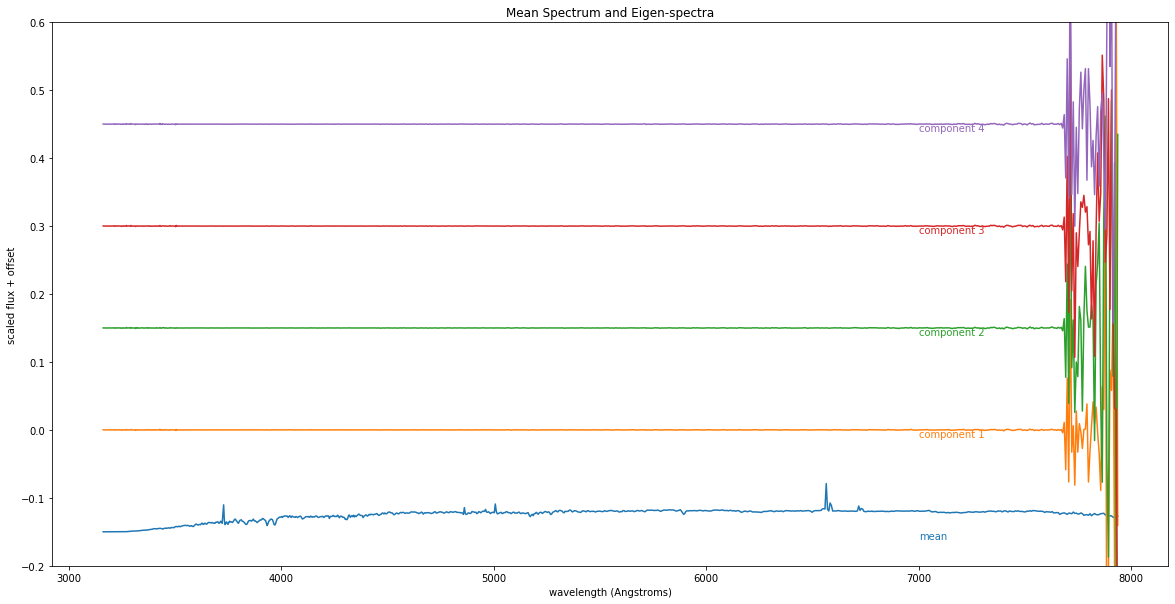

In [54]:
plt.figure(figsize=(20,10))
l = plt.plot(wavelengths, X_normal.mean(axis=0) - 0.15)
c = l[0].get_color()
plt.text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = plt.plot(wavelengths, evecs_fs[i] + 0.15 * i)
    c = l[0].get_color()
    plt.text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
plt.ylim(-0.2, 0.6)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux + offset')
plt.title('Mean Spectrum and Eigen-spectra')